In [1]:
'''
performed truncated svd (similar to pca but faster for large sparse matrices)
with two components, there is no clear separation between cuisines
this is not surprising since the explained variance is very low for even 100 components
'''

import numpy as np
import pandas as pd

data = pd.read_json('train.json')
# get the list of ingredients
ingredientList = sorted(list(set([ingredient for i in range(data.shape[0]) for ingredient in data.loc[i,'ingredients']])))
# the mapping between ingredient and its index
ingredient2index = dict(zip(ingredientList, range(len(ingredientList))))
# create a binary matrix indicating whether or not an ingredient is in a recipe
binaryIngredientsMat = np.zeros((data.shape[0], len(ingredientList)))
for iRecipe in range(data.shape[0]):
    binaryIngredientsMat[iRecipe, [ingredient2index[ingredient] for ingredient in data.loc[iRecipe, 'ingredients']]] = 1
dataBinaryIngredients = pd.DataFrame(binaryIngredientsMat, columns=ingredientList)

def convert( bool ):
    if bool:
        return 1
    else: return 0

convert = np.vectorize(convert)

def negate( bool ):
    return not bool

negate = np.vectorize(negate)

def splitTrainingTesting(X):

    df_test = X.sample(frac=.2, random_state=3) 

    df_train = X.drop(df_test.index)

    return df_test, df_train

df_test, df_train = splitTrainingTesting(dataBinaryIngredients)

Xtrain = df_train.values
Xtest = df_test.values

dataBinaryIngredients.head()

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
def convertBack(a):
    if a==1:
        return True
    else: return False
    
convertBack = np.vectorize(convertBack)

In [2]:
#pca, source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
#https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/principal-components/interpret-the-results/key-results/
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD#actually using truncated svd instead of pca -- X is too large and sparse for PCA

#rescale
scaler = StandardScaler()
XtrainRescaled = scaler.fit_transform(Xtrain)
XtestRescaled = scaler.transform(Xtest)
print('done1')

pca = TruncatedSVD(n_components=2)
principalComps = pca.fit_transform(Xtrain)
principalCompsTest = pca.transform(Xtest)
print('done2')

pcaRescaled = TruncatedSVD(n_components=2)
principalCompsRescaled = pcaRescaled.fit_transform(XtrainRescaled)
principalCompsRescaledTest = pcaRescaled.transform(XtestRescaled)
print('done3')

done1
done2
done3


In [3]:
print(pca.explained_variance_ratio_, '% variance explained by 2 comps: ', pca.explained_variance_ratio_.sum()*100)
print(pcaRescaled.explained_variance_ratio_, 'rescaled % variance explained by 2 comps: ', pcaRescaled.explained_variance_ratio_.sum()*100)

[0.0237141  0.02568339] % variance explained by 2 comps:  4.939749096661647
[0.00105503 0.00104067] rescaled % variance explained by 2 comps:  0.20956995537339132


In [4]:
#looking at most significant terms in each principal component
myList = np.array(ingredientList)
for i in range(2):
    arr = myList[abs(pca.components_[i, :]) > 0.1]
    print(arr)

['all-purpose flour' 'butter' 'garlic' 'garlic cloves'
 'ground black pepper' 'olive oil' 'onions' 'pepper' 'salt' 'sugar'
 'vegetable oil' 'water']
['all-purpose flour' 'baking powder' 'butter' 'eggs' 'garlic'
 'garlic cloves' 'ground black pepper' 'large eggs' 'milk' 'olive oil'
 'onions' 'salt' 'sugar' 'tomatoes' 'unsalted butter' 'vanilla extract']


In [6]:
#computing reconstruction error on test sets
#https://stackoverflow.com/questions/36566844/pca-projecting-and-reconstruction-in-scikit
Xtemp = pca.transform(Xtrain)
print(Xtemp.shape)
Xprojected = pca.inverse_transform(Xtemp)

from random import randint

tots=5

nums = np.zeros(tots)

for k in range(tots):
    #estimating recon error - matrices too big to compute exactly
    sum2 = 0
    total = Xtrain.shape[0]*Xtrain.shape[1]//100
    for i in range(total):
        row = randint(0, Xtrain.shape[0]-1)
        col = randint(0, Xtrain.shape[1]-1)
        sum2 += (Xtrain[row, col] - Xprojected[row,col])**2
    nums[k] = sum2/total
        
print('truncated svd train reconstruction error', nums.mean(), nums.std())

(31819, 2)
truncated svd train reconstruction error 0.0014371033284296577 2.543092130374478e-05


In [11]:
Xtemp = pca.transform(Xtest)
print(Xtemp.shape)
Xprojected = pca.inverse_transform(Xtemp)

from random import randint

#estimating recon error - matrices too big to compute exactly
sum2 = 0
total = Xtest.shape[0]*Xtest.shape[1]//100
for i in range(total):
    row = randint(0, Xtest.shape[0]-1)
    col = randint(0, Xtest.shape[1]-1)
    sum2 += (Xtest[row, col] - Xprojected[row,col])**2
print('truncated svd train reconstruction error', sum2/total)

(7955, 2)
truncated svd train reconstruction error 0.0014318597299629086


In [ ]:
# now visualzing 2d trunc svd, then looking at it for more copmonents

In [30]:
data['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [49]:
train_ids = df_train.index.values
test_ids = df_test.index.values

In [51]:
targets = ['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian']
labelsTrain = []
labelsTest = []
for i in range(len(targets)):
    tempTrain = (data.loc[train_ids,'cuisine'] == targets[i]).values
    tempTest = (data.loc[test_ids,'cuisine'] == targets[i]).values
    labelsTrain.append(tempTrain)
    labelsTest.append(tempTest)

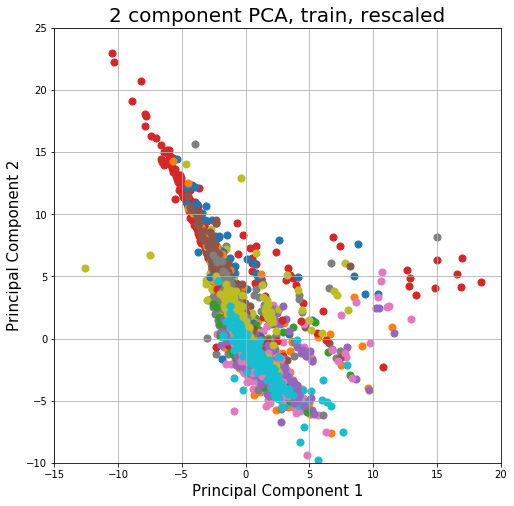

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns=100

# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(xmin=-15, xmax=20)
ax.set_ylim(ymin=-10, ymax=25)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA, train, rescaled', fontsize = 20)
targets = ['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian']
for i in range(len(targets)):
    ax.scatter(principalCompsRescaled[labelsTrain[i],0], principalCompsRescaled[labelsTrain[i],1], s = 50)
#ax.legend(targets)
ax.grid()

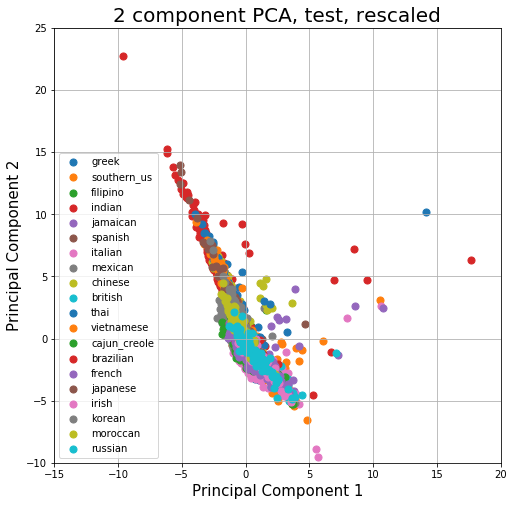

In [104]:
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns=100

# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(xmin=-15, xmax=20)
ax.set_ylim(ymin=-10, ymax=25)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA, test, rescaled', fontsize = 20)
targets = ['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian']
for i in range(len(targets)):
    ax.scatter(principalCompsRescaledTest[labelsTest[i],0], principalCompsRescaledTest[labelsTest[i],1], s = 50)
ax.legend(targets)
ax.grid()

In [105]:
#pca, source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
#https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/principal-components/interpret-the-results/key-results/
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD#actually using truncated svd instead of pca -- X is too large and sparse for PCA

#rescale
scaler = StandardScaler()
XtrainRescaled = scaler.fit_transform(Xtrain)
XtestRescaled = scaler.transform(Xtest)
print('done1')

pca = TruncatedSVD(n_components=100)
principalComps = pca.fit_transform(Xtrain)
principalCompsTest = pca.transform(Xtest)
print('done2')

pcaRescaled = TruncatedSVD(n_components=100)
principalCompsRescaled = pcaRescaled.fit_transform(XtrainRescaled)
principalCompsRescaledTest = pcaRescaled.transform(XtestRescaled)
print('done3')

done1
done2
done3


In [106]:
print(pca.explained_variance_ratio_, '% variance explained by 2 comps: ', pca.explained_variance_ratio_.sum()*100)
print(pcaRescaled.explained_variance_ratio_, 'rescaled % variance explained by 2 comps: ', pcaRescaled.explained_variance_ratio_.sum()*100)

[0.02371413 0.02568341 0.0214298  0.01796216 0.01594879 0.0149748
 0.01372122 0.01262568 0.01169843 0.01098334 0.01026449 0.00945333
 0.00877491 0.00835095 0.00817761 0.00751245 0.00725644 0.00718356
 0.00662091 0.0063949  0.00619074 0.00600571 0.00578552 0.0054751
 0.00537698 0.00514913 0.00501786 0.00489706 0.00462392 0.00454047
 0.00448035 0.00431145 0.00427331 0.00413659 0.00411507 0.00404067
 0.00391827 0.00390464 0.00382576 0.00376108 0.003765   0.00369137
 0.00362573 0.00360637 0.00350555 0.00344866 0.00338977 0.00333362
 0.00330677 0.00327724 0.00322232 0.00317592 0.00311945 0.00303446
 0.00299443 0.0029643  0.00292801 0.00288773 0.00286583 0.00285795
 0.00282672 0.00282501 0.00275206 0.00270757 0.00267607 0.00265017
 0.00263719 0.0025941  0.0025731  0.00254561 0.0025103  0.00248586
 0.00243557 0.0024278  0.00239583 0.00235897 0.00234512 0.00231929
 0.00230527 0.00227048 0.00225648 0.00221841 0.00220302 0.00215595
 0.00214024 0.00212964 0.00211365 0.00208648 0.00207683 0.002046

In [110]:
#looking at most significant terms in each principal component
myList = np.array(ingredientList)
for i in range(100):
    arr = myList[abs(pca.components_[i, :]) > 0.1]
    print(arr)

['all-purpose flour' 'butter' 'garlic' 'garlic cloves'
 'ground black pepper' 'olive oil' 'onions' 'pepper' 'salt' 'sugar'
 'vegetable oil' 'water']
['all-purpose flour' 'baking powder' 'butter' 'eggs' 'garlic'
 'garlic cloves' 'ground black pepper' 'large eggs' 'milk' 'olive oil'
 'onions' 'salt' 'sugar' 'tomatoes' 'unsalted butter' 'vanilla extract']
['corn starch' 'fresh ginger' 'garlic' 'garlic cloves' 'ginger'
 'green onions' 'olive oil' 'onions' 'rice vinegar' 'salt' 'scallions'
 'sesame oil' 'soy sauce' 'sugar' 'vegetable oil' 'water']
['garlic' 'garlic cloves' 'ground black pepper' 'kosher salt' 'large eggs'
 'olive oil' 'onions' 'pepper' 'salt' 'sugar' 'water']
['all-purpose flour' 'butter' 'eggs' 'garlic' 'garlic cloves'
 'ground black pepper' 'kosher salt' 'large eggs' 'olive oil' 'onions'
 'salt' 'sugar' 'unsalted butter' 'water']
['all-purpose flour' 'butter' 'garlic' 'green onions' 'large eggs' 'milk'
 'olive oil' 'onions' 'pepper' 'salt' 'sesame oil' 'soy sauce'
 'unsalt

In [111]:
#looking at most significant terms in each principal component
myList = np.array(ingredientList)
for i in range(100):
    arr = myList[abs(pcaRescaled.components_[i, :]) > 0.1]
    print(arr)

['Hawaiian salt' 'aÃ§ai' 'cacao nibs' 'cashew butter' 'chia seeds'
 'coconut flakes' 'edible flowers' 'frozen mango' 'frozen mixed berries'
 'granola' 'hemp seeds' 'instant coffee' 'medjool date' 'pitted cherries'
 'raw almond' 'raw buckwheat groats' 'sliced mango']
['Hawaiian salt' 'all-purpose flour' 'cumin seed' 'frozen mango'
 'garam masala' 'garlic paste' 'ginger' 'green chilies' 'ground turmeric'
 'oil' 'raw buckwheat groats' 'sliced mango' 'soy sauce']
['brown rice flour' 'buckwheat flour' 'buckwheat honey' 'flaxseed'
 'garbanzo bean flour' 'gluten-free oat' 'millet' 'pectin'
 'psyllium husks' 'sponge' 'sunflower seeds' 'teff']
['chili powder' 'corn starch' 'ground cumin' 'olive oil' 'onions'
 'rice vinegar' 'scallions' 'sesame oil' 'soy sauce' 'sugar']
['clove' 'coriander powder' 'cumin seed' 'garam masala' 'garlic paste'
 'green cardamom' 'green chilies' 'ground turmeric' 'red chili powder'
 'vanilla extract']
['avocado' 'black beans' 'chili powder' 'corn tortillas' 'cumin'
 '

0.4986664129974959


Text(0, 0.5, 'fraction of explained variance')

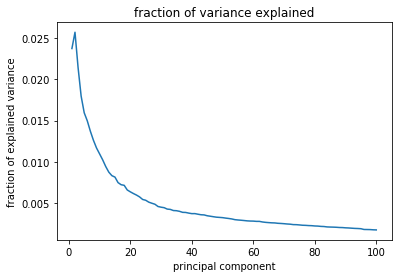

In [113]:
print(np.sum(pca.explained_variance_ratio_))
xxx = np.array(range(1,101))
plt.plot(xxx,pca.explained_variance_ratio_)
plt.title('fraction of variance explained')
plt.xlabel('principal component')
plt.ylabel('fraction of explained variance')

[167.7930876   90.91409235  83.45617257  77.01802124  71.95748176
  69.4468884   66.57739884  63.74212545  61.35629032  59.65340025
  57.56879166  55.16115842  53.17841581  51.87809757  51.30470901
  49.19134909  48.54717714  48.09434545  46.16224865  45.3966521
  44.63389967  44.01369536  43.14832828  42.03033112  41.6016161
  40.75966897  40.18410832  39.71192225  38.57707342  38.22667236
  37.97312275  37.28185149  37.09900124  36.50119996  36.39343719
  36.09248112  35.52542898  35.44762364  35.08970224  34.82621019
  34.80790721  34.48099863  34.15977205  34.06888919  33.58912651
  33.31354575  33.03818485  32.75785784  32.62438543  32.47487003
  32.20228378  31.96893514  31.69988433  31.25031008  31.04385145
  30.88908798  30.70797099  30.48482622  30.3684789   30.32634781
  30.17942386  30.15288114  29.75937427  29.51902612  29.35481822
  29.20548095  29.13608295  28.89257258  28.77942547  28.62148743
  28.42240299  28.28797224  27.99604249  27.95324598  27.76649608
  27.5813457

Text(0, 0.5, 'singular value')

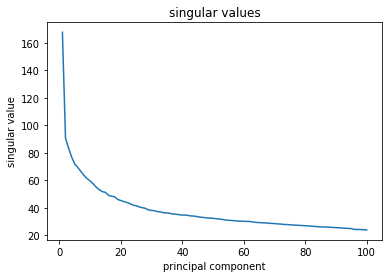

In [114]:
print(pca.singular_values_)
xxx = np.array(range(1,101))
plt.plot(xxx,pca.singular_values_)
plt.title('singular values')
plt.xlabel('principal component')
plt.ylabel('singular value')

0.04621395125692676


Text(0, 0.5, 'fraction of explained variance')

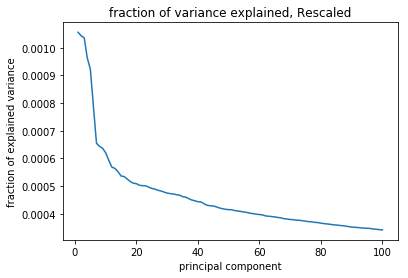

In [115]:
print(np.sum(pcaRescaled.explained_variance_ratio_))
xxx = np.array(range(1,101))
plt.plot(xxx,pcaRescaled.explained_variance_ratio_)
plt.title('fraction of variance explained, Rescaled')
plt.xlabel('principal component')
plt.ylabel('fraction of explained variance')

[462.49079412 459.69789653 458.09863205 441.71530665 432.2282695
 399.4461418  364.18611696 360.94985096 359.05239393 354.34484929
 346.55514491 339.34160639 337.92417461 334.3315407  329.59123763
 328.95131717 326.16049111 323.28004236 321.51564078 320.86000303
 319.09828085 318.67084702 318.46188282 316.98322553 315.471598
 314.69221726 313.33803185 312.45451717 311.19564374 309.96715137
 309.39068645 308.98180848 308.08179048 307.60625521 305.77115445
 305.24422964 303.47072467 301.72658037 300.81151768 299.67515455
 299.39674707 297.13666049 295.22987965 294.72410413 294.42594698
 293.27859649 291.93000228 290.97246467 290.22387904 289.81271893
 289.65099643 288.56476815 288.12586543 287.45353858 286.87197149
 286.16645365 285.14477272 284.80433122 283.97949086 283.55166352
 283.08204703 281.8148048  281.3437018  280.94418305 280.46339973
 279.74499671 279.24164021 278.11710568 277.74298494 277.07209233
 276.88997588 276.1277493  276.04342418 275.43306712 274.89715932
 274.27323316

Text(0, 0.5, 'singular value')

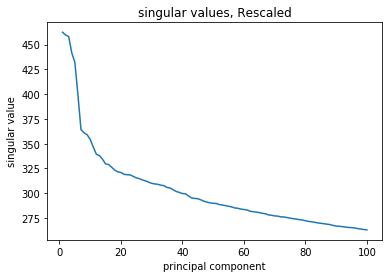

In [116]:
print(pcaRescaled.singular_values_)
xxx = np.array(range(1,101))
plt.plot(xxx,pcaRescaled.singular_values_)
plt.title('singular values, Rescaled')
plt.xlabel('principal component')
plt.ylabel('singular value')